In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/JKM.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['气库-东北亚lng价格'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,气库-东北亚lng价格,JKM-TTF（$/MMBTU）,天然气TTF连1价格,欧元/美元
2025-11-27,NaN,NaN,NaN,NaN
2025-11-28,NaN,NaN,NaN,NaN
2025-12-01,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN


In [5]:
sheet.loc[:last_day, '气库-东北亚lng价格'] = sheet.loc[:last_day, '气库-东北亚lng价格'].interpolate(method='linear')

In [6]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/欧元-美元_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/欧元-美元_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/Horizon-Insights/宏观经济/eta/欧元-美元_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/欧元-美元_合并数据.xlsx")
]

file_path1 = None
for path in file_paths1:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path1 = path
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['欧元/美元'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()


,Date,欧元/美元_预测
17,2025-11-10,1.156100
16,2025-11-11,1.155719
15,2025-11-12,1.156425
14,2025-11-13,1.156916
13,2025-11-14,1.157444


In [7]:
file_path2 = os.path.expanduser("eta/天然气TTF连1价格_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['实际值'])
sheet2 = sheet2.dropna()
sheet2 = sheet2.rename(columns={'天然气TTF连1价格': 'ttf价格'})
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,ttf价格
19,2025-11-10,31.06
18,2025-11-11,31.31
17,2025-11-12,31.47
16,2025-11-13,30.05
15,2025-11-14,31.56


In [8]:
file_path3 = os.path.expanduser("eta/JKM_TTF_合并数据.xlsx") 
sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3.head()

,Date,预测值
19,2025-11-10,0.5802
18,2025-11-11,0.4814
17,2025-11-12,0.4897
16,2025-11-13,0.5150
15,2025-11-14,0.3991


In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '欧元/美元_预测']],
    on='Date',
    how='left'
)
sheet_daily['欧元/美元'] = sheet_daily['欧元/美元'].fillna(sheet_daily['欧元/美元_预测'])
sheet_daily = sheet_daily.drop(columns=['欧元/美元_预测'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', 'ttf价格']],
    on='Date',
    how='left'
)
sheet_daily['天然气TTF连1价格'] = sheet_daily['天然气TTF连1价格'].fillna(sheet_daily['ttf价格'])
sheet_daily = sheet_daily.drop(columns=['ttf价格'])

# sheet 3
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['JKM-TTF（$/MMBTU）'] = sheet_daily['JKM-TTF（$/MMBTU）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,气库-东北亚lng价格,JKM-TTF（$/MMBTU）,天然气TTF连1价格,欧元/美元
6895,2025-11-20,NaN,0.3968,31.47,1.159928
6896,2025-11-21,NaN,0.5006,31.34,1.160970
6897,2025-11-24,NaN,0.4827,31.28,1.160632
6898,2025-11-25,NaN,0.4305,31.53,1.160344
6899,2025-11-26,NaN,0.4557,31.53,1.160175
6900,2025-11-27,NaN,0.4623,31.37,1.162714
6901,2025-11-28,NaN,0.4342,29.94,1.161243
6902,2025-12-01,NaN,0.4651,29.82,1.159890
6903,2025-12-02,NaN,0.4656,29.88,1.159930
6904,2025-12-03,NaN,0.4105,29.54,1.159071


In [10]:
sheet_daily['JKM_预测']  = sheet_daily['天然气TTF连1价格'] * sheet_daily['欧元/美元'] * (15.2/52) + sheet_daily['JKM-TTF（$/MMBTU）']
# 同时显示原始数据
sheet_daily

,Date,气库-东北亚lng价格,JKM-TTF（$/MMBTU）,天然气TTF连1价格,欧元/美元,JKM_预测
6255,2023-06-01,8.8530,1.6110,23.161,1.069700,8.853017
6256,2023-06-02,8.8185,1.4112,23.654,1.076300,8.853003
6257,2023-06-05,8.7840,-0.1028,28.440,1.069000,8.784044
6258,2023-06-06,9.0770,1.2808,24.966,1.068300,9.076990
6259,2023-06-07,8.3990,0.1426,26.356,1.071700,8.399043
...,...,...,...,...,...,...
6900,2025-11-27,NaN,0.4623,31.370,1.162714,11.124030
6901,2025-11-28,NaN,0.4342,29.940,1.161243,10.597041
6902,2025-12-01,NaN,0.4651,29.820,1.159890,10.575415
6903,2025-12-02,NaN,0.4656,29.880,1.159930,10.596607


In [11]:
'''
#  设置图形大小
plt.figure(figsize=(30, 8))

# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 准备需要归一化的数据
data_to_normalize = sheet_daily[['JKM_预测', 'JKM-TTF（$/MMBTU）', '天然气TTF连1价格', '欧元/美元']]
normalized_data = scaler.fit_transform(data_to_normalize)

# 绘制归一化后的数据
plt.plot(sheet_daily['Date'], normalized_data[:, 0], color='purple', linestyle='-', label='JKM预测')
plt.plot(sheet_daily['Date'], normalized_data[:, 1], color='blue', linestyle='--', label='JKM-TTF')
plt.plot(sheet_daily['Date'], normalized_data[:, 2], color='green', linestyle='--', label='TTF价格') 
plt.plot(sheet_daily['Date'], normalized_data[:, 3], color='red', linestyle='--', label='欧元/美元')

# 设置标题和网格
plt.title('天然气价格及相关指标(归一化后)')
plt.grid(True)

# 添加图例
plt.legend()

plt.tight_layout()
plt.show()
'''

"\n#  设置图形大小\nplt.figure(figsize=(30, 8))\n\n# 对数据进行归一化处理\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\n\n# 准备需要归一化的数据\ndata_to_normalize = sheet_daily[['JKM_预测', 'JKM-TTF（$/MMBTU）', '天然气TTF连1价格', '欧元/美元']]\nnormalized_data = scaler.fit_transform(data_to_normalize)\n\n# 绘制归一化后的数据\nplt.plot(sheet_daily['Date'], normalized_data[:, 0], color='purple', linestyle='-', label='JKM预测')\nplt.plot(sheet_daily['Date'], normalized_data[:, 1], color='blue', linestyle='--', label='JKM-TTF')\nplt.plot(sheet_daily['Date'], normalized_data[:, 2], color='green', linestyle='--', label='TTF价格') \nplt.plot(sheet_daily['Date'], normalized_data[:, 3], color='red', linestyle='--', label='欧元/美元')\n\n# 设置标题和网格\nplt.title('天然气价格及相关指标(归一化后)')\nplt.grid(True)\n\n# 添加图例\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n"

---

In [12]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '气库-东北亚lng价格']]
historical.columns = ['Date', 'JKM']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', 'JKM_预测']]
forecast.columns = ['Date', 'JKM_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/JKM_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily

,Date,JKM,JKM_预测
649,2025/12/03,NaN,10.418811
648,2025/12/02,NaN,10.596607
647,2025/12/01,NaN,10.575415
646,2025/11/28,NaN,10.597041
645,2025/11/27,NaN,11.124030
...,...,...,...
4,2023/06/07,8.3990,NaN
3,2023/06/06,9.0770,NaN
2,2023/06/05,8.7840,NaN
1,2023/06/02,8.8185,NaN


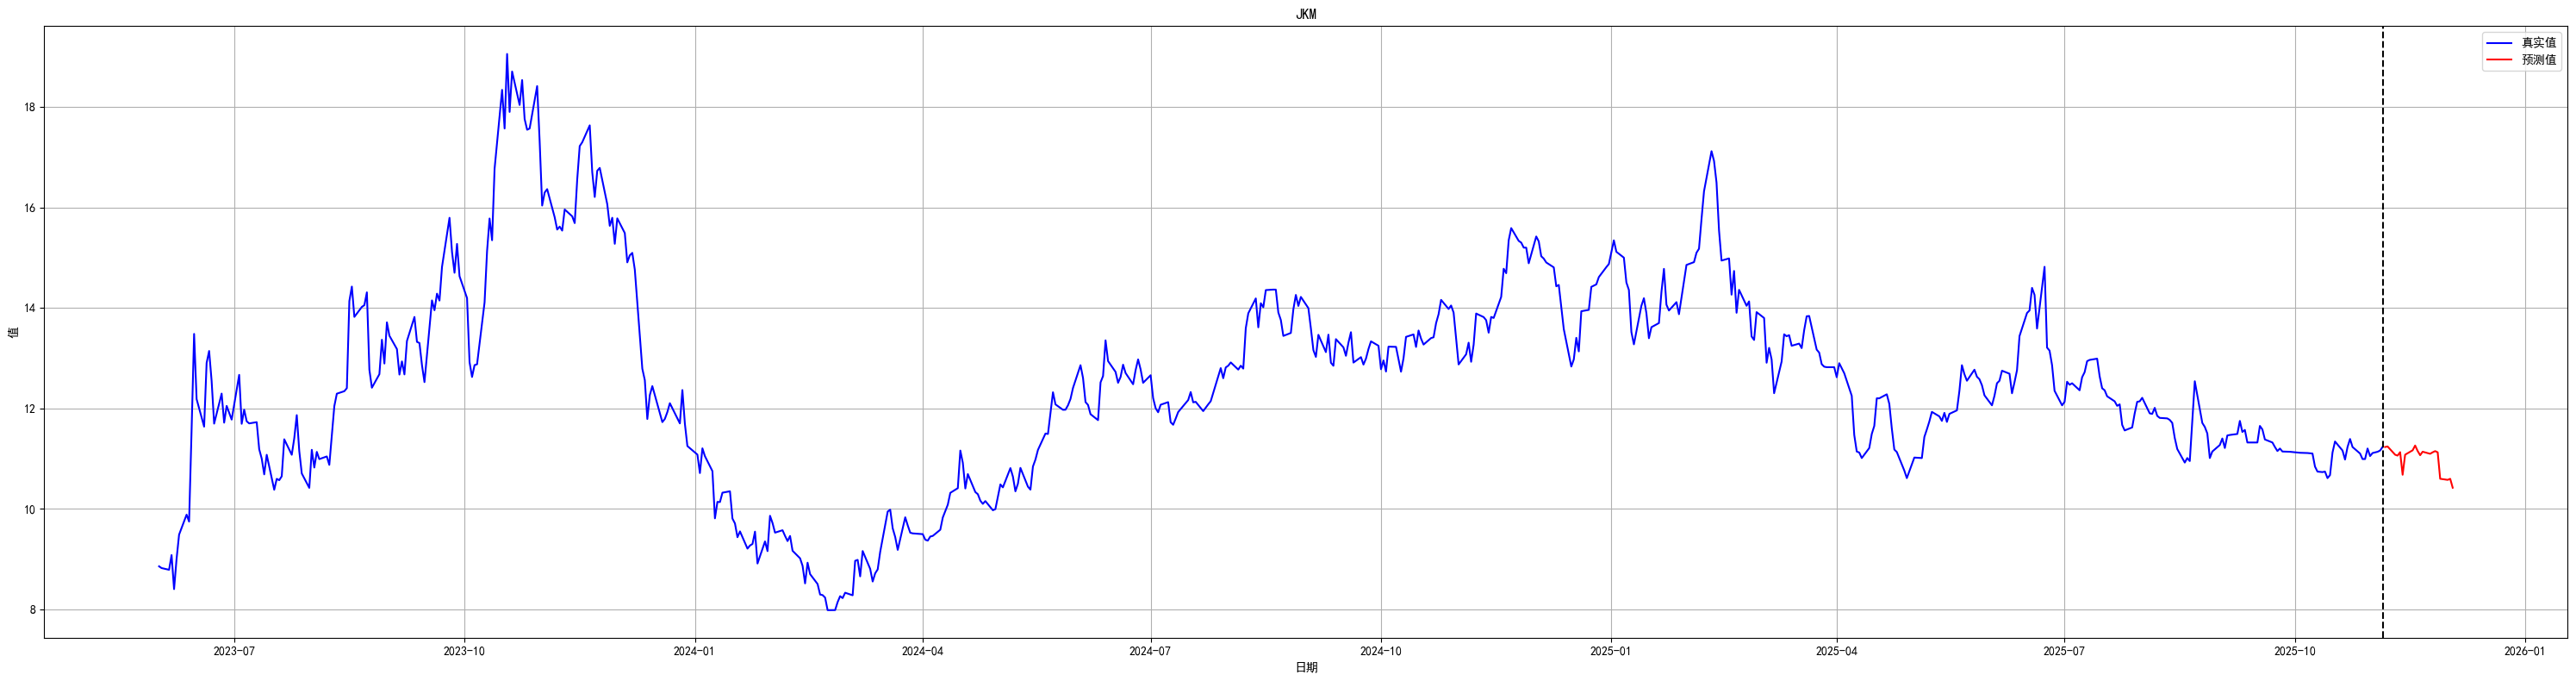

In [13]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['JKM'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['JKM_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('JKM')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '气库-东北亚lng价格']]
historical_monthly.columns = ['Date', 'JKM']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', 'JKM_预测']]
forecast_monthly.columns = ['Date', 'JKM_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/JKM_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,JKM,JKM_预测
30,2025/12/31,NaN,10.530278
29,2025/11/30,11.158750,11.095228
28,2025/10/31,11.032708,11.036521
27,2025/09/30,11.364773,11.371365
26,2025/08/31,11.605000,11.636658
25,2025/07/31,12.311087,12.309994
24,2025/06/30,13.065238,13.065244
23,2025/05/31,12.044286,12.049514
22,2025/04/30,11.689091,11.629016
21,2025/03/31,13.194857,13.194864


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "JKM"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.天然气_数据上传.xlsx"
sheet_name = "详情页"
identifier = "JKM"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [17]:
count_prediction = merged_df_daily.copy()
# 将实际值和预测值合并为一列
count_prediction['预测叠加'] = count_prediction['JKM'].fillna(count_prediction['JKM_预测'])
# 将日期列转换为datetime格式
count_prediction['Date'] = pd.to_datetime(count_prediction['Date'])
# 设置日期为索引
count_prediction.set_index('Date', inplace=True)
# 获取每月最后一天的数据
count_monthly_data = count_prediction.resample('ME').last()
# 重置索引并格式化日期
count_monthly_data = count_monthly_data.reset_index()
count_monthly_data['Date'] = count_monthly_data['Date'].dt.strftime('%Y/%m/%d')
# 显示结果
print(count_monthly_data[['Date', '预测叠加']].tail())

          Date       预测叠加
26  2025/08/31  11.140000
27  2025/09/30  11.130000
28  2025/10/31  11.050000
29  2025/11/30  10.597041
30  2025/12/31  10.418811
